# Project overview and data set 

The main aim of this project is to build a Deep Learning Convolutional Neural Network model to identify brain tumor from the MRI images of subjects. 

The data set used for this work is from the following Kaggle source: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection. The data consists of two folders <code>yes</code> and <code>no</code>. 

<code>yes</code> : Folder contains images of brain tumor

<code>no</code> : folder contains images that are non-cancerous.

# Setting up the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import shutil
import imutils
import cv2
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
%matplotlib inline

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/apple/miniconda3/envs/cta-dev/lib

In [2]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Dividing the data into train, test and validation samples

I will first check the number of files in the two directories and then divide the data into three sets:

<code>TRAIN</code>: This will be used for training the CNN model

<code>VALID</code>: This will be used as the validation dataset during training

<code>TEST</code>: This data set will be untouched during training and will be used as an independent test data set.

Within each directory we will have two sub-folders comtaining images called <code>yes</code> and <code>no</code>

In [3]:
BASE = '/Users/apple/Documents/DATASCIENCE_PY/MRI_brain/MRI_brain_tumor_detect/brain_tumor_dataset/'
YES = BASE+'yes'
NO = BASE+'no'

# Count the number of images in total
def file_counter(dirnames):
    for directory in dirnames:
        FILE_NUMBER = len(os.listdir(directory))
        print("Directory {} has {} images".format(directory, FILE_NUMBER))
        
file_counter([YES, NO])

Directory /Users/apple/Documents/DATASCIENCE_PY/MRI_brain/MRI_brain_tumor_detect/brain_tumor_dataset/yes has 155 images
Directory /Users/apple/Documents/DATASCIENCE_PY/MRI_brain/MRI_brain_tumor_detect/brain_tumor_dataset/no has 98 images


In [4]:
# Generate the TRAIN, VALIDATION and TEST directorories
for direc in ['TRAIN', 'VALID', 'TEST']:
    if not os.path.isdir(BASE+direc):
        os.makedirs(BASE+direc)
        os.makedirs(BASE+direc+'/'+'yes')
        os.makedirs(BASE+direc+'/'+'no')
    else:
        shutil.rmtree(BASE+direc)
        os.makedirs(BASE+direc)
        os.makedirs(BASE+direc+'/'+'yes')
        os.makedirs(BASE+direc+'/'+'no') 

In [5]:
for CLASS in ['no', 'yes']:
    img_number = len(os.listdir(BASE+CLASS))
    for n, file in enumerate(os.listdir(BASE+CLASS)):
        img = BASE+CLASS+'/'+file
        if n<5:
            shutil.copy(img, BASE+'TEST/'+CLASS+'/'+file)
        elif n<=0.85*img_number:
            shutil.copy(img, BASE+'TRAIN/'+CLASS+'/'+file)
        else:
            shutil.copy(img, BASE+'VALID/'+CLASS+'/'+file)

In [6]:
# Check the number of files inside the newly created TRAIN, TEST and VALID directories
for direc in ['TRAIN', 'VALID', 'TEST']:
    for subdirec in os.listdir(BASE+direc):
        if not subdirec.startswith('.'):   #this is to get rid of the .DS_Store file
            img_number = len(os.listdir(BASE+direc+'/'+subdirec))
            print("Directory {} has {} images in {}".format(direc, img_number, subdirec))
    print('\n')

Directory TRAIN has 79 images in no
Directory TRAIN has 127 images in yes


Directory VALID has 14 images in no
Directory VALID has 23 images in yes


Directory TEST has 5 images in no
Directory TEST has 5 images in yes




# Load the data

In [7]:
def load_data(dir_name):
    X = []
    y = []
    for directory in sorted(os.listdir(BASE+dir_name)):
        if not directory.startswith('.'):
            for filename in os.listdir(BASE+dir_name+'/'+directory):
                img = cv2.imread(BASE+dir_name+'/'+directory+'/'+filename)
                X.append(img)
                if directory=='no':
                    y.append(0)
                else:
                    y.append(1)
    X, y = shuffle(np.array(X), np.array(y))
    return X, y

In [8]:
X_train, y_train = load_data('TRAIN')
X_valid, y_valid = load_data('VALID')
X_test, y_test = load_data('TEST')

# Exploratory Data Analysis

Text(0.5, 1.0, 'Test')

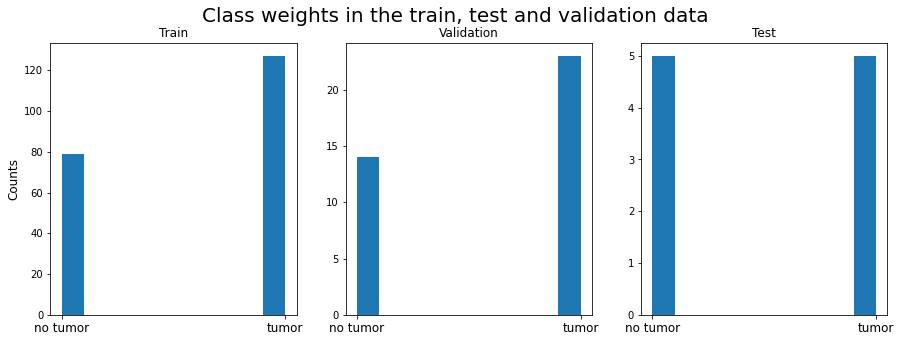

In [9]:
# Visualize the number of entries in each class for the TRAIN, TEST and VALIDATION data set
fig = plt.figure(figsize=(15, 5))
plt.suptitle('Class weights in the train, test and validation data', fontsize=20)
ax1 = fig.add_subplot(1,3,1)
ax1.hist(y_train)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['no tumor', 'tumor'], fontsize=12)
ax1.set_title('Train')
ax1.set_ylabel('Counts', fontsize=12)
ax2 = fig.add_subplot(1,3,2)
ax2.hist(y_valid)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['no tumor', 'tumor'], fontsize=12)
ax2.set_title('Validation')
ax3 = fig.add_subplot(1,3,3)
ax3.hist(y_test)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['no tumor', 'tumor'], fontsize=12)
ax3.set_title('Test')

In [10]:
# View some sample images of tumor and non-tumor images from the train data
def plot_sample_img(X_train, y_train):
    plt.figure(figsize=(12, 12))
    plt.tight_layout()

    tumor_mask = y_train==1
    for i, img in enumerate(X_train[tumor_mask][:5]):
        plt.subplot(1, 5, i+1)
        plt.title("Brain tumor")
        plt.imshow(img)

    
    plt.figure(figsize=(12, 12))
    for i, img in enumerate(X_train[~tumor_mask][:5]):
        plt.subplot(1, 5, i+1)
        plt.title("No Brain tumor")
        plt.imshow(img)

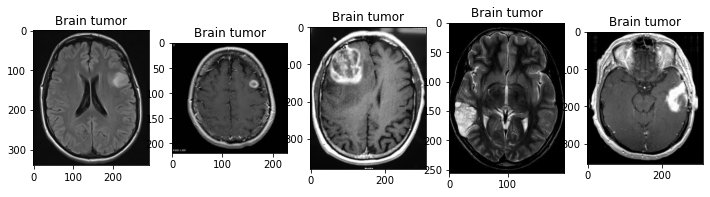

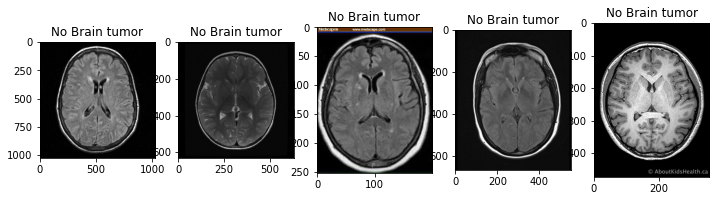

In [11]:
plot_sample_img(X_train, y_train)

# Finding extreme points in the image

The brain images have different kind of shapes and different sizes of black corners. To get only the image of the brain out uniformly for all images, i.e. to reduce the black corners and make them uniform for all images, the following steps are applied:
1. The contour of the btain is identified from the image
2. The extreme points of the contour are located
3. A rectangle is cropped from the identified image corners to extract only the image of the brain.

The technique used here is the one described in the following post: https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

In [12]:
X_train[0].shape

(1024, 1024, 3)

In [13]:
def crop_img(images, draw=False):
    cropped_img_list = []
    for image in images:
        # load the image, convert it to grayscale, and blur it slightly
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # Find the extreme points in the contour
        extleft = tuple(c[c[:, :, 0].argmin()][0])
        extright = tuple(c[c[:, :, 0].argmax()][0])
        exttop = tuple(c[c[:, :, 1].argmin()][0])
        extbot = tuple(c[c[:, :, 1].argmax()][0])
        
        crop = image[exttop[1]:extbot[1], extleft[0]:extright[0]]
        cropped_img_list.append(crop)
        
        plot_cont = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)
        
        ext_pnt = cv2.circle(plot_cont.copy(), extleft, 8, (0, 0, 255), -1)
        ext_pnt = cv2.circle(ext_pnt, extright, 8, (0, 0, 255), -1)
        ext_pnt = cv2.circle(ext_pnt, exttop, 8, (0, 0, 255), -1)
        ext_pnt = cv2.circle(ext_pnt, extbot, 8, (0, 0, 255), -1)
        
        if draw:
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(1,3,1)
            ax1.imshow(plot_cont)
            ax1.set_title("Contour extraction")
            ax2 = fig.add_subplot(1,3,2)
            ax2.imshow(ext_pnt)
            ax2.set_title("Extreme points identification")
            ax3 = fig.add_subplot(1,3,3)
            ax3.imshow(crop)
            ax3.set_title("Cropped Image")
    return np.array(cropped_img_list)

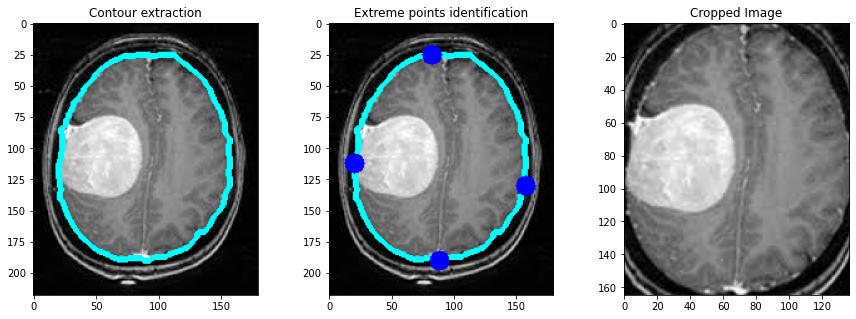

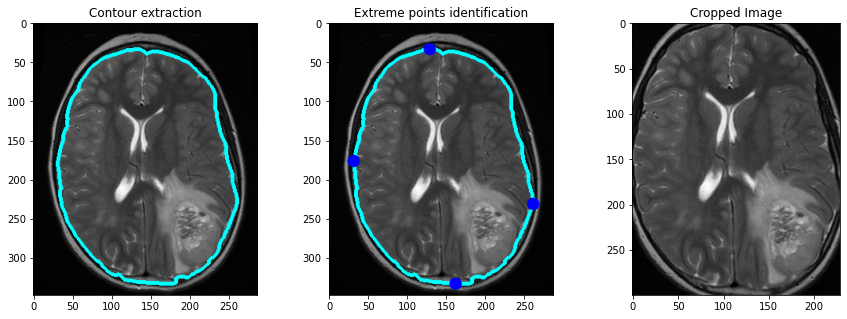

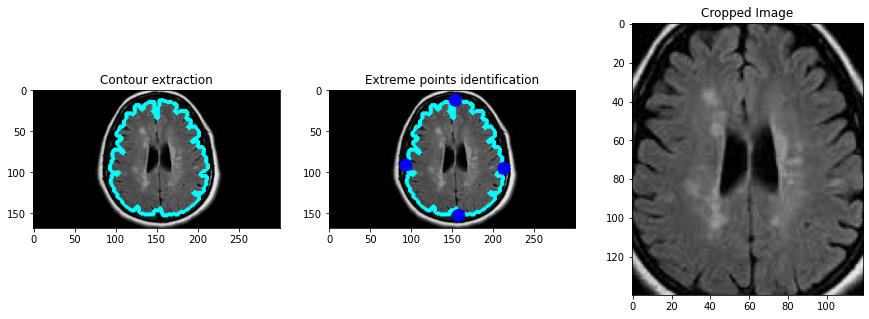

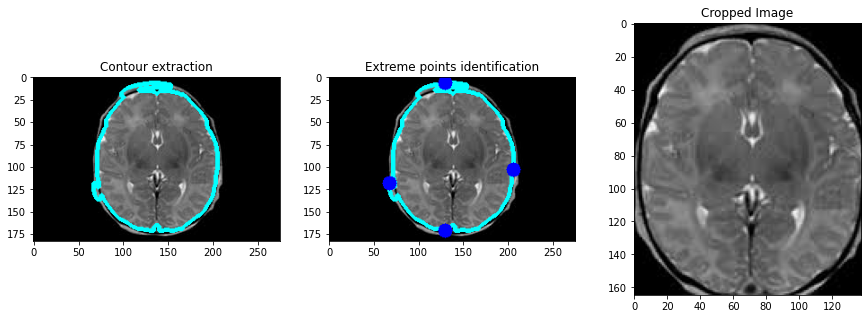

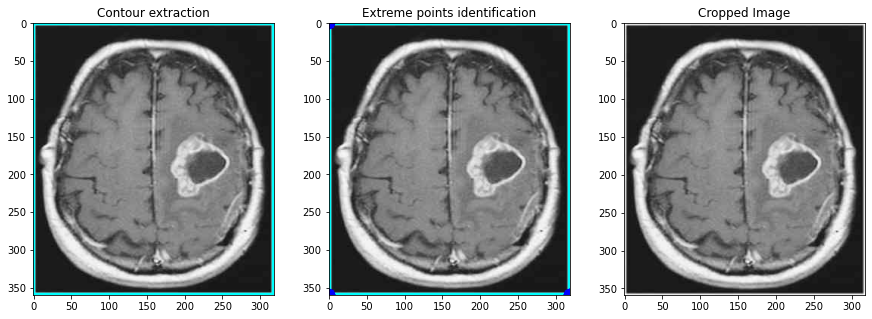

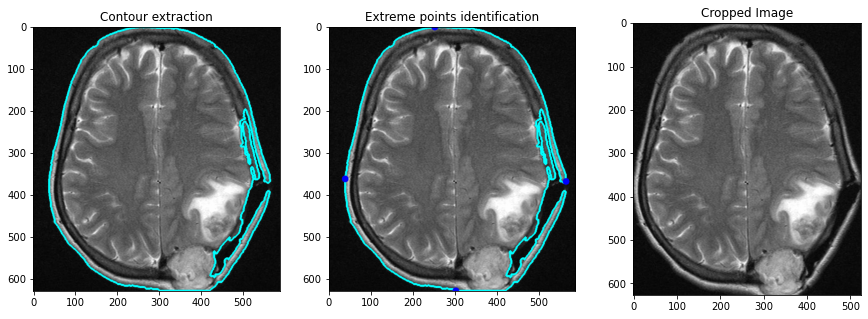

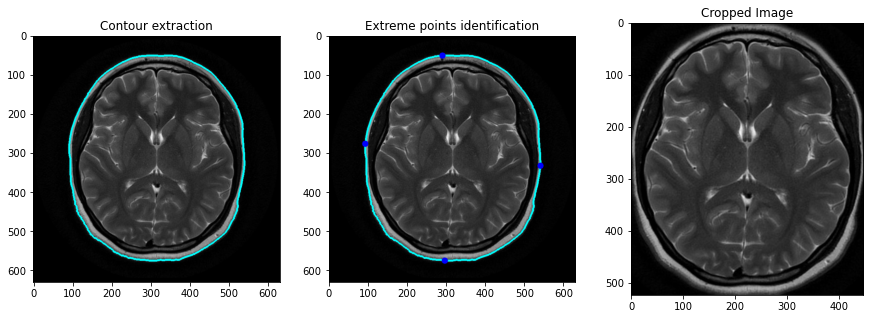

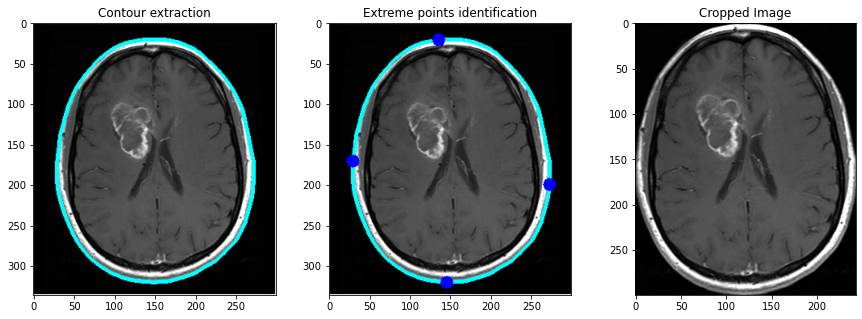

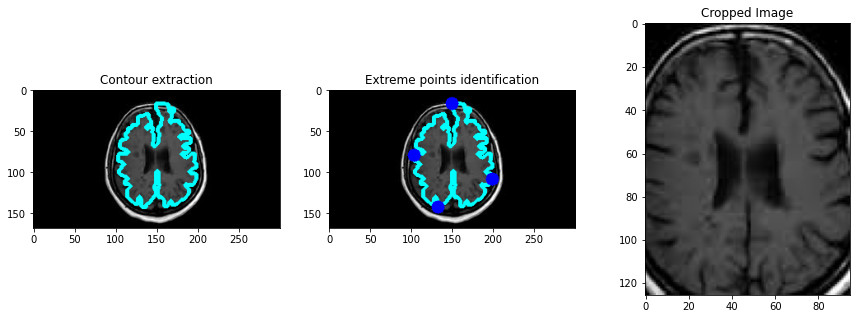

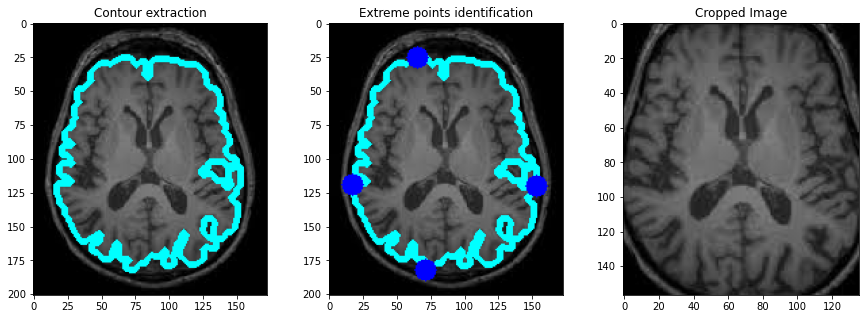

In [14]:
X_test_crop = crop_img(X_test, draw=True)
X_train_crop = crop_img(X_train, draw=False)
X_valid_crop = crop_img(X_valid, draw=False)

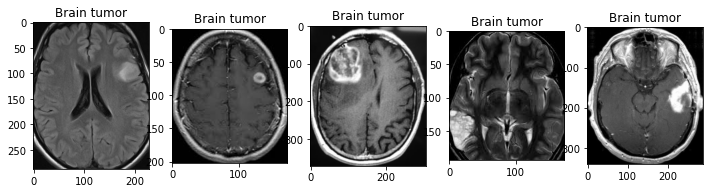

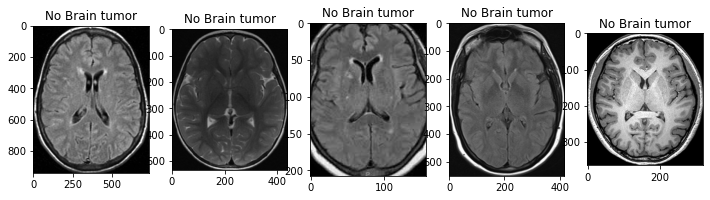

In [15]:
plot_sample_img(X_train_crop, y_train)

# Normalization and resizing

The cropped images have to be resized because all the images have a different shape. Also they need to be normalized so that they have a mean of 0 and variance 1. This is done because if a particular feature has a very large variance compared to others, the objective function is often dominated by this feature and hence it cannot learn effectively from the other features as expected.

In [16]:
def norm_img(images, img_size=(100, 100)):
    scaler = StandardScaler()
    processed_img = []
    
    for img in images:
        # Resize image
        norm = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
        # Normalize each color channel
        #for channel in range(norm.shape[2]):
        #    norm[:,:, channel] = scaler.fit_transform(norm[:,:, channel])
        processed_img.append(norm)
        
    return np.array(processed_img)

In [17]:
X_train_norm = norm_img(X_train_crop, img_size=(224, 224))
X_test_norm = norm_img(X_test_crop, img_size=(224, 224))
X_valid_norm = norm_img(X_valid, img_size=(224, 224))

# Data Augumentation 

Since our dataset is quite small we will use Data Augumentation techniques to randomly perform image transformations on individual images and increase the size of the training and validation data sets.

In [18]:
# First I save the Normalized images into a new folder with name e.g. TRAIN_norm (same for validation)
def create_normdir(X, y, type='train'):
    if not os.path.isdir(BASE+type.upper()+'/'+type.upper()+'_norm'):
        os.makedirs(BASE+type.upper()+'/'+type.upper()+'_norm')
        os.makedirs(BASE+type.upper()+'/'+type.upper()+'_norm'+'/'+'yes')
        os.makedirs(BASE+type.upper()+'/'+type.upper()+'_norm'+'/'+'no')
    else:
        shutil.rmtree(BASE+type.upper()+'/'+type.upper()+'_norm')
        os.makedirs(BASE+type.upper()+'/'+type.upper()+'_norm')
        os.makedirs(BASE+type.upper()+'/'+type.upper()+'_norm'+'/'+'yes')
        os.makedirs(BASE+type.upper()+'/'+type.upper()+'_norm'+'/'+'no')
        
    yes_mask = y==1
    tumor_img = X[yes_mask]
    nontumor_img = X[~yes_mask]
    
    for i, img in enumerate(tumor_img):
        cv2.imwrite(BASE+type.upper()+'/'+type.upper()+'_norm'+'/'+'yes'+'/'+str(i)+'.jpg', img)
        
    for i, img in enumerate(nontumor_img):
        cv2.imwrite(BASE+type.upper()+'/'+type.upper()+'_norm'+'/'+'no'+'/'+str(i)+'.jpg', img)
 
# CREATE THE DIRECTORIES WITH NORMALIZED IMAGES
create_normdir(X_train_norm, y_train, type='train')
create_normdir(X_valid_norm, y_valid, type='valid')
create_normdir(X_test_norm, y_test, type='test')

In [19]:
TRAIN_DATA = BASE+'TRAIN/'+'TRAIN_norm'
VALID_DATA = BASE+'VALID/'+'VALID_norm'
TEST_DATA = BASE+'TEST/'+'TEST_norm'

batch_size=32
img_size=(224, 224)


traingen = ImageDataGenerator(rotation_range=30, 
                              width_shift_range=0.1, 
                              height_shift_range=0.0, 
                              shear_range=0.1, 
                              brightness_range=[0.5, 1.5], 
                              horizontal_flip=True, 
                              vertical_flip=True, 
                              preprocessing_function=preprocess_input
                             )

train_generator = traingen.flow_from_directory(TRAIN_DATA, 
                   color_mode="rgb", 
                   batch_size=batch_size, 
                   target_size=img_size, 
                   class_mode='binary', 
                   seed=42)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = test_datagen.flow_from_directory(
    VALID_DATA,
    color_mode='rgb',
    target_size=img_size,
    batch_size=16,
    class_mode='binary',
    seed=42
)

Found 206 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


# Convolutional Neural Network

In [20]:
num_class = 1

weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(weights)

[1.30379747 0.81102362]


### The VGG16 CNN model

In [21]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

epochs=40
batch=50


base_model = VGG16(include_top=False, weights='imagenet', input_shape=img_size + (3,))

model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

earlystop = EarlyStopping(monitor='val_acc', mode='max', patience=10)

modelchkpoint = ModelCheckpoint('./best_weights_vgg16.hdf5', 
                                monitor='val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                save_weights_only=False, 
                                verbose=1)

rmsprop = RMSprop(lr=1e-4)
model.compile(loss='binary_crossentropy', 
              optimizer=rmsprop, 
              metrics=['accuracy'])

print(model.summary())

for layer in model.layers:
    print(layer.name, layer.trainable)
    
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              steps_per_epoch=batch, 
                              validation_data=validation_generator, 
                              validation_steps=batch*0.5, 
                              callbacks=[earlystop, modelchkpoint],  
                              verbose=1)

best_model_vgg16 = keras.models.load_model('./best_weights_vgg16.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1254450   
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 15,969,189
Trainable params: 1,254,501
Non-trainable params: 14,714,688
_________________________________________________________________
None
vgg16 False
flatten True
dense True
dropout True
dense_1 True
Epoch 1/40
49/50 [============================>.] - ETA

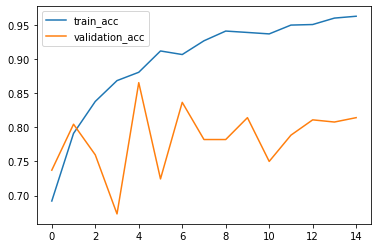

In [23]:
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='validation_acc')
plt.legend()